In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/Soil Classification Project/Working_Data'

/content/drive/MyDrive/Soil Classification Project/Working_Data


In [1]:
# Preprocessing on dataset
import cv2 as cv
import zlib
import base64
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from itertools import product
import datetime as dt
import ast
import empiricaldist
from scipy.signal import hamming
import math as mt
import scipy
import statistics as st
from time import time

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Machine Learning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Deep Learning
#import tensorflow as tf
#import tensorflow_hub as hub
#import keras

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score, make_scorer
# Parameter tuning

# Variables to run
#tf.config.run_functions_eagerly(True)
#tf.experimental.numpy.experimental_enable_numpy_behavior()


In [2]:
## Implement sharpening and check performance of fourier, it behaved wrong after denoising the sand image which is expected. 
## Implement the primitive color indication on a normalized and unnormalized level. I might let the models decide which they
## prefer. I hope sharpening solves the naive particle estimation problem

In [3]:
# Feature Engineering Functions

def get_color(rgb_image, normalize=True):

    # Find the index of the maximum value for each pixel along the RGB axis
    max_index = np.argmax(rgb_image, axis=-1)
    
    # Convert to float32 to avoid overflow during division
    rgb_image = rgb_image.astype(np.float32)

    # Find the maximum value in image
    _max = np.max(rgb_image)
    
    normalized_image = rgb_image/_max

    # Create an array where we will store the thousand values
    thousand_values = np.zeros_like(max_index)

    # Assign 1000 to pixels where red is max, 2000 for green, and 3000 for blue
    thousand_values[max_index == 0] = 1000  # Red channel
    thousand_values[max_index == 1] = 2000  # Green channel
    thousand_values[max_index == 2] = 3000  # Blue channel

    # Get the maximum pixel value per channel (if normalize is true, normalize the layers, normalize isn't implemented yet)
    if normalize is True:
        max_rgb_values = np.max(normalized_image, axis=-1)
    else:
        max_rgb_values = np.max(rgb_image, axis=-1)

    # Add the thousand values to the maximum RGB values
    result = max_rgb_values + thousand_values

    # Extract percentiles to get an idea of the dominant color
    return [np.percentile(result, perc) for perc in range(10, 101,10)]

def get_fourier_radius(fourier_image, r=125):
    rows, cols = fourier_image.shape
    crow, ccol = int(rows / 2), int(cols / 2)

    center = [crow, ccol]
    
    #ogrid creates arrays with values specified in braces e.g x, y = np.ogrid[:5, :5] creates first array with 5 rows of 0-5
    #and second array with 5 columns of 0-5
    x, y = np.ogrid[:rows, :cols]
    # this is simply the formula of a circle, it's very crucial to subtract the half of the shape in this equation as it makes
    # the centroid index value gotten from ogrid to be 0 and note that we use the truth table to filter from main image
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
    mask_area = fourier_image[mask_area]
    med=np.median(mask_area)
    return med

def get_fourier_distribution(fourier_image):
    return [np.percentile(fourier_image, perc) for perc in range(10, 101, 10)]

'''def apply_window(image):
    # Get the image size
    h, w = image.shape
    # Generate Hamming window
    window = np.outer(hamming(h), hamming(w))
    # Apply window
    return image * window'''

def get_sharpened_image(image, alpha=2.5, beta=-1.5, gamma=0, sigma=2, sharp_scale=1, blur_scale=0):
    gaus_blur=cv.GaussianBlur(image, (5,5), sigma)
    sharpened=cv.addWeighted(image, alpha, gaus_blur, beta, gamma)
    #plt.imshow(sharpened*sharp_scale + gaus_blur*blur_scale, cmap='gray')
    #plt.show()
    #print('KK')
    return sharpened*sharp_scale + gaus_blur*blur_scale

def get_fourier(image, visualize=True):
    image = cv.imread('test_data/'+image)
    
    # Converting to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    color_image=image
    color_image = cv.resize(color_image, (500,500))

    # 1. Converting to grayscale
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    #print(image.shape)
    
    #Apply Median Filtering
    #image = cv.medianBlur(image, 5)
    #image=cv.GaussianBlur(img1_resized, (5, 5), 0)
        
    # 2. Resizing
    image_grz = cv.resize(image, (500,500))
    #median = cv.medianBlur(image_grz, 3)
    #bi = cv.bilateralFilter(test_image_gray, 5, 200, 200)
    
    # 3. Histogram Equalization
    image = cv.equalizeHist(image_grz)
    image = 0.3*image_grz + 0.7*image

    # 4. Sharpen image
    #gaus_blur=cv.GaussianBlur(image_grz, (5,5), 2)
    image=get_sharpened_image(image_grz)
    # add weighted is basically applying a formula dst=α⋅src1+β⋅src2+γ(0 in this case)
    #cv.imwrite('tt.jpg', image)
    #image=cv.GaussianBlur(image_grz, (5, 5), 0)
    #image = cv.medianBlur(image_grz, 5)

    # 5. Changing to Uint8
    image = np.uint8(image)
    #image=apply_window(image)
    
    # Perform the 2D Fourier Transform
    dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

    # Calculate the magnitude spectrum
    magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1]))
    #mag=magnitude_spectrum[250,200:250]

    # Display the original image and its magnitude spectrum
    if visualize==True:
        plt.figure(figsize=(7,5))
        plt.subplot(131), plt.imshow(color_image, cmap='gray')
        plt.title('Color Image'), plt.axis('off')
        plt.subplot(132), plt.imshow(image, cmap='gray')
        plt.title('Gray Image'), plt.axis('off')
        plt.subplot(133), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.axis('off')
        plt.show()
    else:
        pass
    
    return magnitude_spectrum

def remove_small_skeletons(thinned_image, Tlength):
    _, labels = cv.connectedComponents(thinned_image)

    # The number of labels is max label + 1 since we do 0 indexing
    num_labels = labels.max() + 1
    kept_labels=0
    #print(num_labels)

    # We create a list to store the skeletons or say the skeleton images where the >= Tlength condition is satisfied
    skeletons = []

    for label in range(1, num_labels):  # Exclude background (label 0)
        # We loop through all the labels and the variable "component" just creates an image where only pixels from a
        # Particular label is shown
        component = (labels == label).astype(np.uint8)
        #print(component)


        # Below after getting all pixels from each label, we sum the pixels from the labels and use basically if the sum
        # of the skeleton from a particular label is small, we take it as noise which makes a whole lot of sense.
        if np.sum(component) >= Tlength:
            skeletons.append(component)
            kept_labels+=1
            #plt.imshow(component)
            #plt.show()

    # Create a new thinned image with the remaining skeletons - we basically join all the skeletons in the skeleton list
    # The skeleton list is where we kept the pixels with long lengths
    thinned_image = np.zeros_like(thinned_image)
    for skeleton in skeletons:
        thinned_image |= skeleton  # Use logical OR to combine skeletons

    return thinned_image, num_labels, kept_labels

def crop_to_square(image):
    """
    Crops the center of an image to make it square if one dimension is 30% larger than the other.
    
    Parameters:
    image (numpy array): Input image as a NumPy array (HxWxC or HxW).
    
    Returns:
    cropped_image (numpy array): Cropped square image.
    """
    # Get the dimensions of the image
    height, width = image.shape[:2]
    #2560, 1123
    # Check if one side is 30% or more larger than the other
    if height >= width * 1.3 or width >= height * 1.3:
        # Determine the smaller dimension
        smaller_dim = min(height, width)
        #print(smaller_dim)
        
        # Calculate the crop coordinates for a centered square
        if height > width:  # Crop height
            top = (height - smaller_dim) // 2
            bottom = top + smaller_dim
            left, right = 0, width
            #print(top,bottom,left,right)
        else:  # Crop width
            left = (width - smaller_dim) // 2
            right = left + smaller_dim
            top, bottom = 0, height
        
        # Crop the image
        cropped_image = image[top:bottom, left:right]
        return cropped_image
    else:
        # If no cropping is needed, return the original image
        return image

# Other Functions
def add_patch(x,y, dist_x, dist_y):
    plt.gca().add_patch(Rectangle((x,y),dist_x,dist_y,
                    edgecolor='red',
                    facecolor='none',
                    lw=3))

## Extra Functions

In [4]:
def generate_perc_dist_columns(perc_distance=5, color_cols=True, fourier=True):
    col_names=['perc_'+str(dist) for dist in range(1,101,perc_distance)]
    col_names.append('mode')
    #col_names.append('distance')
    
    if color_cols == True:
        for c in range(10,101,10):
            col_names.append('color_percentile_'+str(c))
    if fourier==True:
        for four_ in range(10,101,10):
            col_names.append('fourier_distribution_'+str(four_))
        col_names.append('fourier_median')
    return col_names

In [5]:
def preprocess_v2(image_path, canny_x=100, canny_y=350, blend_x=0.7, blend_y=0.3, alpha=2.5, beta=-1.5, gamma=20, Tlength=5,
                 sigma=2, sharp_scale=1, blur_scale=0, square=True):
    '''Returns all the necessary images for further preprocessing'''
    
    image = image_path.reshape((500,500))
    #image = cv.imread(image_path)
    # Converting to RGB
    #image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    #color_image=image

    # Converting to grayscale
    image_gray = image
    #image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    
    # Squaring image before further preprocessing
    #if square == True:
        #image_gray=crop_to_square(image_gray)
    #else:
        #pass
        
    # Resizing image
    gray_resized = image_gray
    #print(np.max(gray_resized))
    gray_resized=np.uint8(gray_resized)
    #print(gray_resized.dtype)
    #gray_resized = cv.resize(image_gray, (500,500))

    # histogram equalization
    hist_equ = cv.equalizeHist(gray_resized)
    blended = blend_x*gray_resized + blend_y*hist_equ
    
    # sharpening the image
    sharp=get_sharpened_image(blended, alpha=alpha, beta=beta, gamma=gamma, sigma=sigma, sharp_scale=sharp_scale,
                             blur_scale=blur_scale)
    
    # converting to uint 8 0-255 pixel value
    sharp = np.uint8(sharp)
    #plt.imshow(sharp, cmap='gray')
    #plt.show()

    # Appling Canny Edge Detection
    canny_edge_img = cv.Canny(sharp, canny_x, canny_y, L2gradient=True)
    canny_edge_img_unit = canny_edge_img/255
    
    # Perform the 2D Fourier Transform
    dft = cv.dft(np.float32(sharp), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

    # Calculate the magnitude spectrum
    magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1]))
    
    # length filtering
    thinned, lab, kept =remove_small_skeletons(canny_edge_img, Tlength)
    #plt.imshow(thinned)
    #plt.show()

    return thinned, magnitude_spectrum, lab, kept

In [6]:
def preprocess(image_path, canny_x=100, canny_y=350, blend_x=0.7, blend_y=0.3):
    image = cv.imread(image_path)
    
    # Converting to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Converting to grayscale
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    # Resizing image
    gray_resized = cv.resize(image_gray, (500,500))

    # histogram equalization
    hist_equ = cv.equalizeHist(gray_resized)

    blended = blend_x*gray_resized + blend_y*hist_equ
    blended = np.uint8(blended)
    #plt.imshow(blended, cmap='gray')
    #plt.show()

    # Appling Canny Edge Detection
    canny_edge_img = cv.Canny(blended, canny_x, canny_y)
    canny_edge_img_unit = canny_edge_img/255

    return canny_edge_img_unit

In [7]:
def get_pixel_sum(full_image, no_of_patches=25):
    size_x=full_image.shape[0]
    size_y=full_image.shape[1]
    down_size=int((size_x*size_y/no_of_patches)**(1/4))
    patches = full_image.reshape(no_of_patches, down_size, down_size, down_size, down_size)
    values=[]

    for img_patch_no in range(no_of_patches):
        image_patch = patches[img_patch_no]
        first_sum = np.sum(image_patch, axis=(1))
        second_sum = np.sum(first_sum, axis=(2))
        values.append(second_sum.flatten())

    final = np.array(values).ravel()
    return final

In [8]:
# Correct get pixel sum function
def get_pixel_sum_v2(full_image, patch_size=10):
    values = []
    current_row = 0
    nxt_row = patch_size
    current_column = 0
    nxt_column = patch_size
    size_x=full_image.shape[0]
    size_y=full_image.shape[1]
    each_loop=int(size_x/patch_size)

    #print(int((size_x*size_y)/(patch_size**2)))
    #for a in range(int((size_x*size_y)/(patch_size**2))):
    for a in range(each_loop):
        for b in range(each_loop):
            patch=full_image[current_row:nxt_row, current_column:nxt_column]
            #print(sum(patch), '=', np.sum(patch))
            #print(current_column, nxt_column)
            val = np.sum(patch)
            values.append(val)
            current_column+=patch_size
            nxt_column+=patch_size
        current_row+=patch_size
        nxt_row+=patch_size
        current_column=0
        nxt_column=patch_size
        #print(values)
    return values

In [9]:
def get_percentiles_distance(naive_particle_sizes, perc_distance=5):
    
    percentiles = []
    for a in range(1,101,perc_distance):
        percentiles.append(np.percentile(naive_particle_sizes, a))
        
    mode=st.mode(naive_particle_sizes)
    percentiles.append(mode)

    #percentiles.append(random_number)

    return percentiles

    #df.loc[len(df)] = percentiles
    #df = df.append(pd.Series(new_record, index=df.columns), ignore_index=True)
    
def get_distances(list_length=100, dist='close', seed=42):
    np.random.seed(seed)
    
    # Define range and standard deviation
    range_min = (20, 50)  # Minimum value in the range
    range_max = (40, 70)  # Maximum value in the range
    std_dev = 3  # Standard deviation

    if dist=='close':
    # Generate a random number with specified range and standard deviation
        random_number = np.random.normal(loc=(range_max[0] + range_min[0]) / 2, scale=std_dev, size=list_length)
        #print(random_number)
        # Ensure the generated number falls within the specified range
        random_number_clip = np.clip(random_number, range_min[0], range_max[0])
        #print(random_number_clip)
    elif dist=='far':
        random_number = np.random.normal(loc=(range_max[1] + range_min[1]) / 2, scale=std_dev, size=list_length)
        random_number_clip = np.clip(random_number, range_min[1], range_max[1])
    
    return random_number_clip

In [10]:
def get_metrics(y_true, y_pred):
    '''Gets the accuracy, micro, macro and weighted recall, precision and f1'''
    micro_prec=precision_score(y_true, y_pred, average='micro')
    macro_prec=precision_score(y_true, y_pred, average='macro')
    weighted_prec=precision_score(y_true, y_pred, average='weighted')
    micro_recall=recall_score(y_true, y_pred, average='micro')
    macro_recall=recall_score(y_true, y_pred, average='macro')
    weighted_recall=recall_score(y_true, y_pred, average='weighted')
    micro_f1=f1_score(y_true, y_pred, average='micro')
    macro_f1=f1_score(y_true, y_pred, average='macro')
    weighted_f1=f1_score(y_true, y_pred, average='weighted')
    accuracy=accuracy_score(y_true, y_pred)
    return micro_prec, macro_prec, weighted_prec, micro_recall, macro_recall, weighted_recall, micro_f1, macro_f1, weighted_f1, accuracy


In [11]:
# Making the dataframe
names=generate_perc_dist_columns(perc_distance=1)
extras=['class', 'image_name', 'no_of_connected_components', 'kept_components','distance']
names.extend(extras)
#names_test=generate_perc_dist_columns()
#names_train.append('class')

working_df_train = pd.DataFrame(columns=names)
working_df_test = pd.DataFrame(columns=names)

# Creating dataframe copies to use in loop
working_df_train_batch=pd.DataFrame(columns=names[:-1])
working_df_test_batch=pd.DataFrame(columns=names[:-1])

## Main Parameter Tuning starts here

In [12]:
%%time
# MASTER PARAM LIST
# Parameters to test

# These kernel shapes have to be multiples of 50
kernel_shapes = [10,20,35]

# These blending ratios are for hist equa and image sharpening
blending_ratios = [(0, 1), (0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7,0.3), (0.8,0.2), (0.9,0.1),
            (1, 0)]
canny_x=list(range(100,301,100))
canny_y=list(range(200,801,100))

alphas=[1.5,2.5,3.5]
betas=[-0.3,-0.5,-1.5]
gammas=list(range(10,60,10))
sigmas=list(range(2,10,2))
Tlengths=list(range(5,50,10))
rads=list(range(10,101,10))

combine_canny=[]
for a in canny_x:
    for b in canny_y:
        combine_canny.append((a,b))

all_parameters= list(product(kernel_shapes, blending_ratios, combine_canny, alphas, betas, gammas, sigmas, Tlengths, rads))

CPU times: total: 1.55 s
Wall time: 1.94 s


In [13]:
len(all_parameters), all_parameters[0]

(6237000, (10, (0, 1), (100, 200), 1.5, -0.3, 10, 2, 5, 10))

In [14]:
# Random Parameters
#1 Nwigwee, #2 Cheta, #3 Troy
np.random.seed(2)
#rand_nos=np.random.randint(low=0, high=1500000, size=10000)
rand_nos=np.random.randint(low=1500001, high=3000000, size=5000) #cheta
#rand_nos=np.random.randint(low=3000001, high=4500000, size=5000) #troy
#rand_nos=np.random.randint(low=4500001, high=6200000, size=5000) #nwigwee
#all_parameters_udoh=[all_parameters[i] for i in rand_nos]
all_parameters_cheta=[all_parameters[i] for i in rand_nos]
#all_parameters_nwigwee=[all_parameters[i] for i in rand_nos]
#all_parameters_troy=[all_parameters[i] for i in rand_nos]

In [15]:
# Creating same dir in Validation dir change Test to Train afterwards to make train and test dirs
#for dir_ in os.listdir('test_data/Useful/Test'):
#    os.mkdir('test_data/Useful/Validation/'+dir_)

In [16]:
soils={"1 inch at 1ft":["close", 0, 28], "1 inch at 2ft":["far", 0, 28], "1.5 inches at 1 ft":["close", 1, 30], 
       "1.5 inches at 2ft":["far", 1, 30], "2 inches at 1ft":["close", 0, 32], "2 inches at 2ft":["far", 0, 32], 
       "Close-Hard-Core":["close", 1, 34], "Far-Hard-Core":["far", 1, 34], "Half inch at 1 ft":["close", 1, 36], 
       "Nsk-Gravel-Big-Close":["close", 1, 38], "Nsk-Gravel-Small-Close":["close", 1, 40], 
       "Nsk-White-Sand-Close":["close", 6, 42], "Red Sand":["close", 4, 44], "rice-at-1-ft":["close", 0, 46], 
       "rice-at-2-ft":["far", 0, 46], "sharp sand at 1ft":["close", 3, 48], "sharp sand at 2ft":["far", 3, 48], 
       "Stone Dust at 1 ft":["close", 2, 50], "Three eight at 1ft":["close", 0, 50], 
       "Three Quarter at 1 ft":["close", 1, 52]}

In [17]:
# Importing images

soil_path='test_data/Useful/Validation/Validation_Image_as_Table/'

unique_classes=['GP','GW','GM','SP','SM', 'SW'] # [0-6]

exempt_keys=["Close-Hard-Core", "Far-Hard-Core", "Nsk-Gravel-Big-Close", "Nsk-Gravel-Small-Close"]

new = ["params","perc_distance", "precision_micro_train", "precision_macro_train", "precision_weighted_train",
        "recall_micro_train", "recall_macro_train", "recall_weighted_train", "f1_micro_train", "f1_macro_train",
        "f1_weighted_train", "accuracy_train", "precision_micro_test", "precision_macro_test", "precision_weighted_test",
        "recall_micro_test", "recall_macro_test", "recall_weighted_test", "f1_micro_test", "f1_macro_test",
        "f1_weighted_test", "accuracy_test"]

In [18]:
# Step 3: Create a DataFrame to store the matrix and metadata
tr_data = {
    'filename': [],
    'image_matrix': [],  # Convert NumPy array to a list for storage
    'shape': [], # Store the shape to reconstruct later
    'image_dir': [],
    'color_percs':[]
}

te_data = {
    'filename': [],
    'image_matrix': [],  # Convert NumPy array to a list for storage
    'shape': [], # Store the shape to reconstruct later
    'image_dir': [],
    'color_percs':[]
}

cols=['filename','image_matrix','shape']

df_train = pd.DataFrame(columns=cols)
df_test = pd.DataFrame(columns=cols)

## Preprocessing Pipeline

In [19]:
%%time
metrics_df_columns=new
metrics_df=pd.DataFrame(columns=metrics_df_columns)

for params in all_parameters_udoh[111:]:
    start_time = dt.datetime.now()
    start_time_conv = start_time.strftime("%Y-%m-%d %H:%M:%S")

    expected_end_time = start_time+dt.timedelta(minutes=34)
    expected_end_time_conv = expected_end_time.strftime("%Y-%m-%d %H:%M:%S")
    print('=====Started process for', params, 'set =====')
    print('Iteration started at:', start_time_conv, 'expected end time is:', expected_end_time_conv)
    
    #Unpacking tuple
    kern, blend_rt, canny_combo, alph, bet, gam, sig, tl, rd = params
    
    working_df_train = pd.DataFrame(columns=names)
    working_df_test = pd.DataFrame(columns=names)
    
    working_df_train_batch=pd.DataFrame(columns=names[:-1])
    working_df_test_batch=pd.DataFrame(columns=names[:-1])

    for soil_key in soils.keys():
        soil_path_new=soil_path+soil_key
        read_train=pd.read_parquet(soil_path_new+'_train.parquet')
        #read_train=read_train.iloc[:5,:]
        read_test=pd.read_parquet(soil_path_new+'_test.parquet')
        #read_test=read_test.iloc[:5,:]
        #soil=sorted(os.listdir(soil_path+soil_key)) #[:10]
        if soil_key in exempt_keys:
            # This means all the data should be test data
            full=pd.concat([read_train, read_test])
            test=full.image_matrix
            test_col=full.color_percs
            test_filenm=full.filename
            train=[]
            train_col=[]
            train_filenm=[]
            #pass
        else:
            train=read_train.image_matrix
            train_col=read_train.color_percs
            train_filenm=read_train.filename
            test=read_test.image_matrix
            test_col=read_test.color_percs
            test_filenm=read_test.filename
        dist_=soils[soil_key][0]
        class_=soils[soil_key][1]
        sd=soils[soil_key][2]
        print(f"For current soil in class {class_}, we have {len(train)} training data and {len(test)} testing data!")

        print ('Working on Training Set')
        tic = time()
        for soil_pic, color_, filenm in tqdm(zip(train,train_col,train_filenm),total=len(train)):
            #print(soil_pic)

            naive_particle_pic, fourier_pic, lab, kept=preprocess_v2(soil_pic, blend_x=blend_rt[0],\
                                blend_y=blend_rt[1], canny_x=canny_combo[0], canny_y=canny_combo[1], alpha=alph, \
                                beta=bet, gamma=gam, Tlength=tl, sigma=sig, sharp_scale=blend_rt[0], blur_scale=blend_rt[1])
            #print(naive_particle_pic, soil_path+soil_pic)
            naive_particle_sum=get_pixel_sum_v2(naive_particle_pic, kern)
            percentiles=get_percentiles_distance(naive_particle_sum, perc_distance=1)
            color_perc=color_.tolist()
            fourier_perc=get_fourier_distribution(fourier_pic)
            fourier_med=get_fourier_radius(fourier_pic, r=rd)
            # get color info
            percentiles.extend(color_perc)
            percentiles.extend(fourier_perc)
            plus=[fourier_med, class_, filenm, lab, kept]
            percentiles.extend(plus)
            working_df_train_batch.loc[len(working_df_train_batch)] = percentiles
        working_df_train_batch['distance']=get_distances(working_df_train_batch.shape[0], seed=sd, dist=dist_)
        working_df_train = pd.concat([working_df_train, working_df_train_batch])
        working_df_train_batch=pd.DataFrame(columns=names[:-1])
        toc = time()
        print(f'Time elapsed: {(toc-tic)/60:0.2f} minutes\n')
        

        print('\n','======Finished Training set=======', '\n')
        print ('Working on Testing Set')
        for soil_pic_test,color_test,fn_test in tqdm(zip(test,test_col,test_filenm), total=len(test)):
            #print(soil_path_new+soil_pic_test)
            naive_particle_pic_test, fourier_pic_test, lab_test, kept_test=preprocess_v2(soil_pic_test,
                                                                                                         blend_x=blend_rt[0],\
                                blend_y=blend_rt[1], canny_x=canny_combo[0], canny_y=canny_combo[1], alpha=alph, \
                                beta=bet, gamma=gam, Tlength=tl, sigma=sig, sharp_scale=blend_rt[0], blur_scale=blend_rt[1])
            #print(naive_particle_pic, soil_path+soil_pic)
            naive_particle_sum_test=get_pixel_sum_v2(naive_particle_pic_test, kern)
            #print(type(naive_particle_sum))
            percentiles_test=get_percentiles_distance(naive_particle_sum_test, perc_distance=1)
            #print(percentiles)
            color_perc_test=color_test.tolist()
            fourier_perc_test=get_fourier_distribution(fourier_pic_test)
            fourier_med_test=get_fourier_radius(fourier_pic_test, r=rd)
            # get color info
            percentiles_test.extend(color_perc_test)
            percentiles_test.extend(fourier_perc_test)
            plus_test=[fourier_med_test, class_, fn_test, lab_test, kept_test]
            percentiles_test.extend(plus_test)
            #print(len(percentiles))
            working_df_test_batch.loc[len(working_df_test_batch)] = percentiles_test
        working_df_test_batch['distance']=get_distances(working_df_test_batch.shape[0], seed=sd+1, dist=dist_)
        working_df_test = pd.concat([working_df_test, working_df_test_batch])
        working_df_test_batch=pd.DataFrame(columns=names[:-1])
        print('\n')
        
    object_dtype=working_df_test.select_dtypes(include=['object']).columns
    for obj in object_dtype:
        if obj!='image_name':
            working_df_train[obj]=working_df_train[obj].astype(float)
            working_df_test[obj]=working_df_test[obj].astype(float)

    dec_tree = DecisionTreeClassifier(random_state=88, max_depth=25)
    dec_tree.fit(working_df_train.drop(['class', 'image_name'], axis=1), working_df_train[['class']])
    print(working_df_train.shape, working_df_test.shape)
    print('Saving Dfs')
    working_df_train.to_csv('Parameter-Tuning-Results/params_csvs/train_df'+str(params)+'.csv')
    working_df_test.to_csv('Parameter-Tuning-Results/params_csvs/test_df'+str(params)+'.csv')
    
    y_pred_tr=dec_tree.predict(working_df_train.drop(['class', 'image_name'], axis=1))
    y_pred_te=dec_tree.predict(working_df_test.drop(['class', 'image_name'], axis=1))

    precision_micro_train, precision_macro_train,precision_weighted_train,recall_micro_train,recall_macro_train, recall_weighted_train,f1_micro_train,f1_macro_train,f1_weighted_train, accuracy_train=get_metrics(working_df_train[['class']],y_pred_tr)
    precision_micro_test, precision_macro_test,precision_weighted_test,recall_micro_test,recall_macro_test,recall_weighted_test,f1_micro_test,f1_macro_test,f1_weighted_test, accuracy_test=get_metrics(working_df_test[['class']],y_pred_te)
    metrics_df.loc[len(metrics_df)] = [params, 1, precision_micro_train, precision_macro_train,precision_weighted_train,recall_micro_train,recall_macro_train,recall_weighted_train,f1_micro_train,f1_macro_train,f1_weighted_train, accuracy_train, precision_micro_test,precision_macro_test,precision_weighted_test,recall_micro_test,recall_macro_test,recall_weighted_test,f1_micro_test,f1_macro_test,f1_weighted_test, accuracy_test]
    if metrics_df.shape[0] in list(range(10, 20001, 10)):
        metrics_df.to_csv('metrics'+str(metrics_df.shape[0])+str(params)+'.csv')

=====Started process for (10, (0.8, 0.2), (200, 400), 3.5, -0.5, 50, 4, 35, 10) set =====
Iteration started at: 2024-11-22 21:59:54 expected end time is: 2024-11-22 22:33:54
For current soil in class 0, we have 105 training data and 45 testing data!
Working on Training Set


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [06:58<00:00,  3.99s/it]
<timed exec>:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Time elapsed: 6.98 minutes


 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:49<00:00,  3.77s/it]
<timed exec>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`




For current soil in class 0, we have 105 training data and 45 testing data!
Working on Training Set


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [06:29<00:00,  3.71s/it]
<timed exec>:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Time elapsed: 6.49 minutes


 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:41<00:00,  3.60s/it]
<timed exec>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`




For current soil in class 1, we have 105 training data and 45 testing data!
Working on Training Set


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [06:19<00:00,  3.62s/it]
<timed exec>:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Time elapsed: 6.33 minutes


 ======Finished Training set======= 

Working on Testing Set


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [02:36<00:07,  3.64s/it]

KeyboardInterrupt



## Generating Reports

In [ ]:
def class_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict= True)
    report_df = pd.DataFrame(report).transpose()
    n = [range(4)]
    n.append('accuracy')
    n.append('macro avg')
    n.append('weighted avg')
    report_df.index = n
    return report_df

In [36]:
def get_cnn_plot(mod_history_var, metric='f1_metric'):
  ## Plotting the loss
  train_ = history.history[metric]
  val_ = history.history['val_'+metric]
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(8,6))
  plt.xticks(range(1, len(loss) + 1, 5))
  plt.plot(epochs, train_, 'y', label='Training')
  plt.plot(epochs, val_, 'r', label='Validation')

  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend()
  plt.grid()
  #plt.savefig('loss.jpg', dpi = 300, bbox_inches='tight')
  plt.show()


## CNN Functions

In [7]:
def CNN_preprocess(image_path):
    image = cv.imread(image_path)

    # Converting to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image=tf.cast(image, tf.float32)

    # Resizing image
    resized_im = tf.image.resize(image, (224,224))
    resized_im/=255

    return resized_im.numpy()

In [8]:
def preprocess_cnn_pred(pred):
  all_ = []
  for a in pred:
    a_lst= a.tolist()
    max_=max(a_lst)
    ind = a_lst.index(max_)
    all_.append(ind)
  return all_


In [9]:
def f1_metric(y_true, y_pred):
  y_pred=preprocess_cnn_pred(y_pred)
  f1 = f1_score(y_true, y_pred, average='macro')
  return f1

In [44]:
def CNN_model_fit(learning_rate=0.001):
  # Training the Neural Net
  image_size = 224

  url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
  feature_extract = hub.KerasLayer(url, input_shape = (image_size, image_size, 3))
  feature_extract.trainable = False

  mod = tf.keras.Sequential([
      feature_extract,
      tf.keras.layers.Dense(3, activation = 'softmax')
  ])
  learning_rate = learning_rate
  optim = tf.keras.optimizers.Adam(learning_rate)

  mod.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy', f1_metric])

  return mod


# Using the Neural Network

In [10]:
# Training the Neural Net
image_size = 224

url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extract = hub.KerasLayer(url, input_shape = (image_size, image_size, 3))
feature_extract.trainable = False

model = tf.keras.Sequential([
    feature_extract,
    tf.keras.layers.Dense(3, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Setting the Learning rate, metrics to track, etc.

In [11]:
learning_rate = 0.001
optim = tf.keras.optimizers.Adam(learning_rate)

model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy', f1_metric])

## Necessary Callbacks

In [12]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Saving best model
save_best = tf.keras.callbacks.ModelCheckpoint("./best_model.h5", monitor = 'val_loss',
                                              save_best_only = True)

In [13]:
%%time
cnn_train_data_list = []
cnn_test_data_list = []

train_target = []
test_target = []

for soil, soil_path, class_ in zip(all_soils, all_soil_path, [0,1,2,2]):
    train=soil[0:int(len(soil)*0.75)]
    test=soil[int(len(soil)*0.75):]

    for tr_pic in tqdm(train):
        cnn_train_data_list.append(CNN_preprocess(soil_path+tr_pic))
        train_target.append(class_)
    for te_pic in tqdm(test):
        cnn_test_data_list.append(CNN_preprocess(soil_path+te_pic))
        test_target.append(class_)

cnn_train_data = np.array(cnn_train_data_list)
cnn_test_data = np.array(cnn_test_data_list)

train_target_arr =np.array(train_target)
train_target_arr.shape

100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


CPU times: user 1min 50s, sys: 33.9 s, total: 2min 24s
Wall time: 6min 59s


In [14]:
cnn_train_data.shape, train_target_arr.shape

(300, 224, 224, 3)

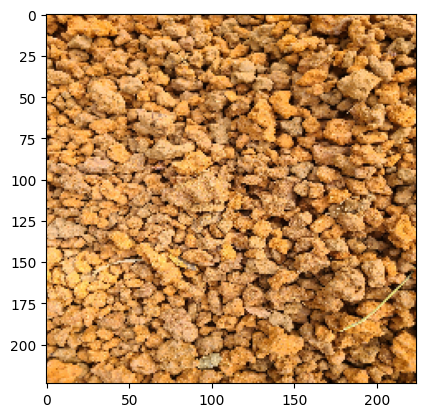

In [18]:
# Displaying one image
plt.imshow(cnn_train_data[0,:,:,:])

In [25]:

# fiting the model
epochs = 2
history = model.fit(x=cnn_train_data,y=train_target_arr,
                       epochs = epochs,
                       validation_split = 0.15,
                       callbacks = [early_stopping, save_best])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/2
8/8 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8941 - f1_metric: 0.8808

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 8s 1s/step - loss: 0.2820 - accuracy: 0.8941 - f1_metric: 0.8808 - val_loss: 0.0204 - val_accuracy: 1.0000 - val_f1_metric: 1.0000
Epoch 2/2
8/8 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9373 - f1_metric: 0.9214

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 9s 1s/step - loss: 0.2242 - accuracy: 0.9373 - f1_metric: 0.9214 - val_loss: 0.0135 - val_accuracy: 1.0000 - val_f1_metric: 1.0000


In [26]:
pred = model.predict(cnn_test_data)
pred_conv = preprocess_cnn_pred(pred)

1/4 [======>.......................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 43ms/step


In [28]:
get_metrics(test_target, pred_conv)

(0.93,
 0.9166666666666666,
 0.9375,
 0.93,
 0.9066666666666666,
 0.93,
 0.93,
 0.9057239057239057,
 0.9292929292929293,
 0.93)

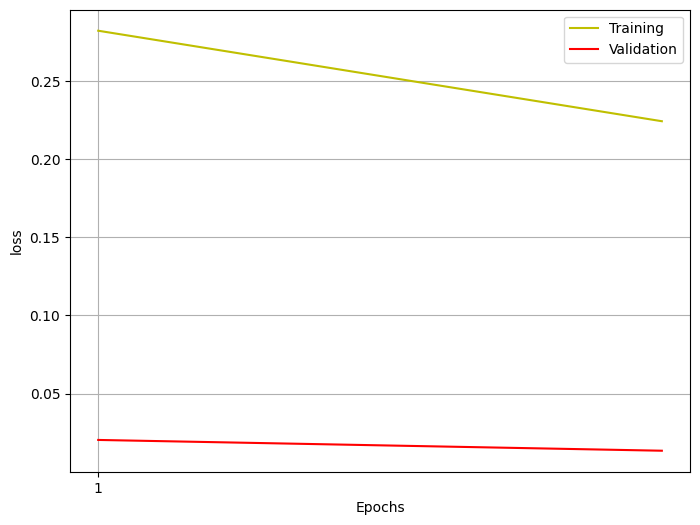

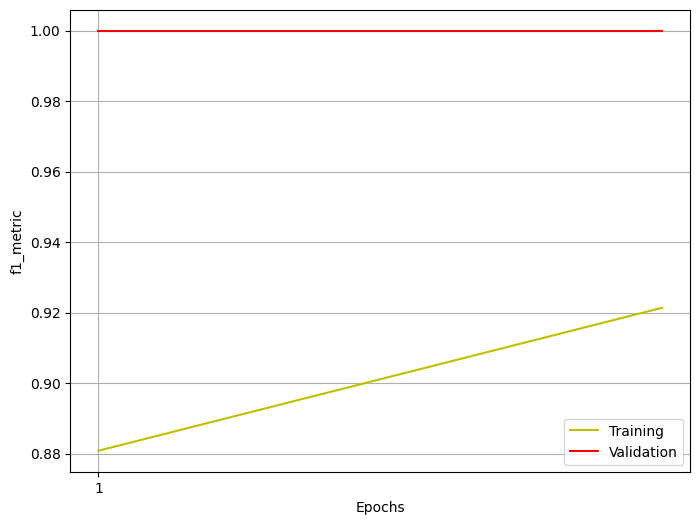

In [37]:
# Loss Plot
get_cnn_plot(history, metric='loss')

# f1_metric plot
get_cnn_plot(history, metric='f1_metric')

## Automated Training and Testing

In [43]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Saving best model
save_best = tf.keras.callbacks.ModelCheckpoint("./best_model.h5", monitor = 'val_loss',
                                              save_best_only = True)

In [45]:
model_ = CNN_model_fit(learning_rate=0.001)

hist_ = model_.fit(x=cnn_train_data,y=train_target_arr,epochs = 2,validation_split = 0.2,callbacks = [early_stopping, save_best])

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 1.4000 - accuracy: 0.3083 - f1_metric: 0.2492

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 14s 1s/step - loss: 1.4000 - accuracy: 0.3083 - f1_metric: 0.2492 - val_loss: 0.4789 - val_accuracy: 0.9667 - val_f1_metric: 0.4915
Epoch 2/2
8/8 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.7042 - f1_metric: 0.6536

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 9s 1s/step - loss: 0.7053 - accuracy: 0.7042 - f1_metric: 0.6536 - val_loss: 0.1195 - val_accuracy: 1.0000 - val_f1_metric: 1.0000


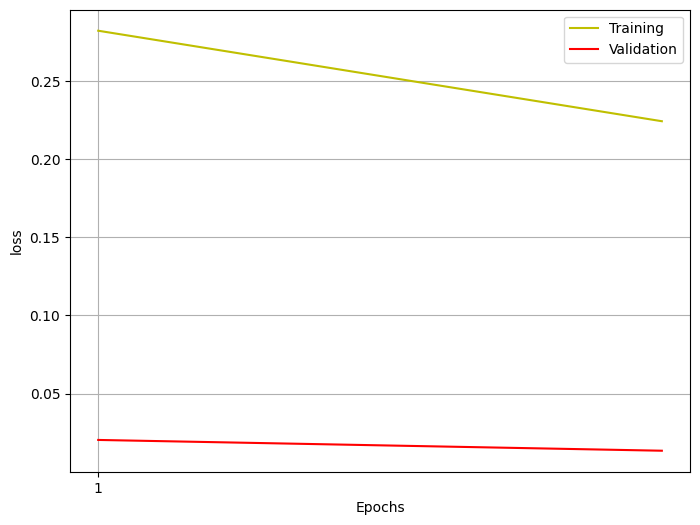

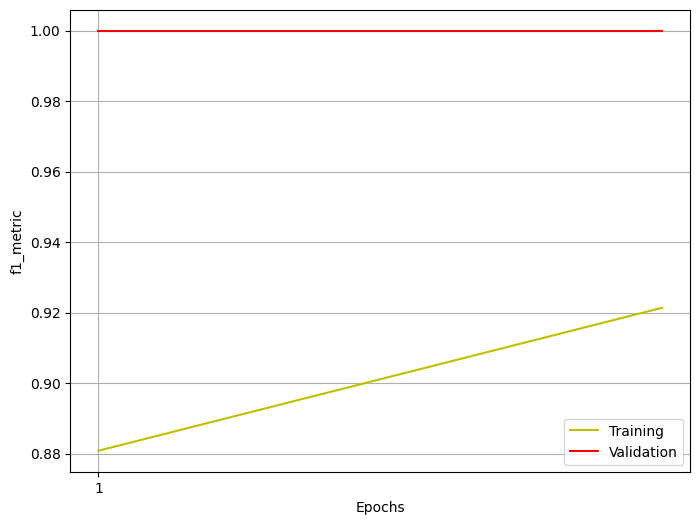

In [46]:
# Loss Plot
get_cnn_plot(hist_, metric='loss')

# f1_metric plot
get_cnn_plot(hist_, metric='f1_metric')

In [47]:
pred1 = model_.predict(cnn_test_data)
pred_conv1 = preprocess_cnn_pred(pred1)

1/4 [======>.......................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 50ms/step


In [48]:
get_metrics(test_target, pred_conv1)

(0.87,
 0.8402777777777778,
 0.8802083333333335,
 0.87,
 0.8266666666666667,
 0.87,
 0.87,
 0.8232014143886849,
 0.8674010607915136,
 0.87)

## Results Analysis
1. Box Plot showing distribution of f1_macro, precision_macro and recall_macro scores. So three plots with just kernel on the xaxis.
2. CDF on just Kernel. This shows the general performance of the kernel like if it's just oene kernel having a high value a box plot might not show that but the cdf will show as just the 100th percentile will show that high value.
3. Blending distribution on a kernel level, x = blending, hue by kernel or column by kernel, any one.
4. I'm still thinking of a way to show this.


In [2]:
results = pd.read_csv('Parameter-Tuning-Results/all_results_all.csv')

# Convert string representation of tuple to actual tuple
results['params'] = results['params'].apply(ast.literal_eval)

In [7]:
def slicer_0(val):
    return val[0]

def slicer_1(val):
    return val[1]

def slicer_2(val):
    return val[2]

def slicer_7(val):
    return val[7]

def slicer_3(val):
    return val[2][0]

def slicer_4(val):
    return val[2][1]

def kernel_shape (val):
    if val==2:
        return '(2x2)'
    elif val==5:
        return '(5x5)'
    else:
        return '(10x10)'

In [7]:
results['kernel'] = results['params'].apply(slicer_0)
results['kernel_shape'] = results['params'].apply(kernel_shape)
results['blending'] = results['params'].apply(slicer_1)
results['canny'] = results['params'].apply(slicer_2)
results['canny_x'] = results['params'].apply(slicer_3)
results['canny_y'] = results['params'].apply(slicer_4)


In [8]:
results.head(2)

,S No.,params,perc_distance,precision_micro_train,precision_macro_train,precision_weighted_train,recall_micro_train,recall_macro_train,recall_weighted_train,f1_micro_train,...,f1_micro_test,f1_macro_test,f1_weighted_test,accuracy_test,kernel,kernel_shape,blending,canny,canny_x,canny_y
0,0,"(2, (0, 1), (50, 200))",1,1,1,1,1,1,1,1,...,0.858934,0.760827,0.854669,0.858934,2,(10x10),"(0, 1)","(50, 200)",50,200
1,1,"(2, (0, 1), (50, 250))",1,1,1,1,1,1,1,1,...,0.786834,0.629478,0.777698,0.786834,2,(10x10),"(0, 1)","(50, 250)",50,250


In [16]:
palette = {'2':'blue', '5':'orange', '10':'green'}

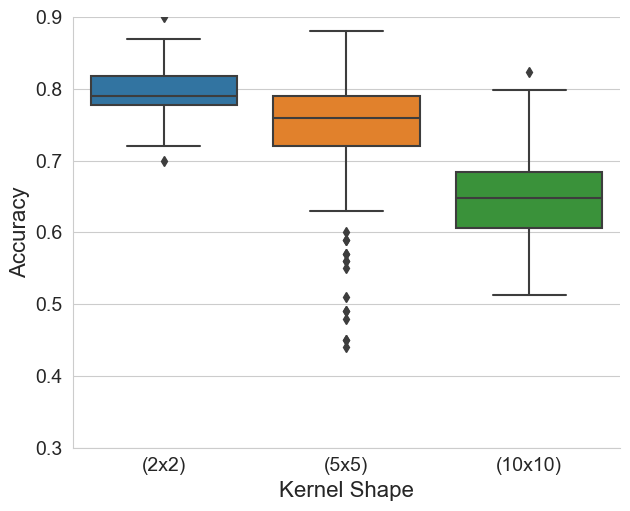

In [96]:
# 1. Box Plot showing distribution of f1_macro, precision_macro and recall_macro scores. So three plots with just kernel on
# the xaxis.

sns.set_style('whitegrid')
ax=sns.catplot(x='kernel', y='accuracy_test', data=results, kind='box', height=5, aspect=1.25)
ax.tick_params(labelsize=14, axis = 'both')
ax.set_xticklabels(['(2x2)', '(5x5)', '(10x10)'])
plt.xlabel('Kernel Shape', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0.3,0.9)
#plt.savefig('acc_paper_plot.jpg', dpi=2000)


In [79]:
def get_prt(df, col, kernel = 2, perc_value=25):
    return np.percentile(df[df['kernel']==kernel][col], perc_value)

In [104]:
# Here I was changing the parameters like the metric values and just changed them in the plot below. I didn't want to have
# to make a variable for each metric
ker_2_25_f1 = get_prt(results, 'accuracy_test')
ker_2_75_f1 = get_prt(results, 'accuracy_test', perc_value=75)
ker_5_25_f1 = get_prt(results, 'accuracy_test', kernel=5)
ker_5_75_f1 = get_prt(results, 'accuracy_test', kernel=5, perc_value=75)
ker_10_25_f1 = get_prt(results, 'accuracy_test', kernel=10)
ker_10_75_f1 = get_prt(results, 'accuracy_test', kernel=10, perc_value=75)

In [105]:
ker_2_25_f1, ker_2_75_f1, ker_5_25_f1, ker_5_75_f1, ker_10_25_f1, ker_10_75_f1

(0.777429467, 0.818181818, 0.72, 0.79, 0.606217617, 0.683937824)

C:\Users\User\AppData\Local\Temp\ipykernel_16840\2997361555.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax=sns.catplot(x='kernel', y='accuracy_test', data=results, kind='swarm', height=5, aspect=1.25, palette=palette, size=4)


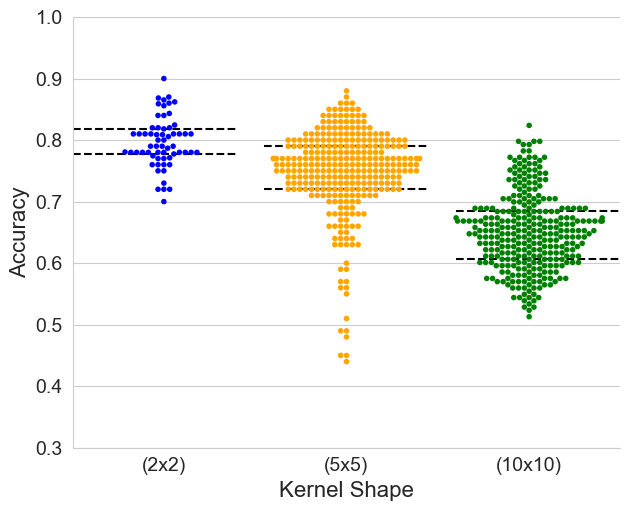

In [106]:
# 2. CDF on just Kernel. This shows the general performance of the kernel like if it's just oene kernel having a high 
# value a box plot might not show that but the cdf will show as just the 100th percentile will show that high value.

# Seems a swarmplot will be better so I ended up using a swarmplot

sns.set_style('whitegrid')
ax=sns.catplot(x='kernel', y='accuracy_test', data=results, kind='swarm', height=5, aspect=1.25, palette=palette, size=4)
ax.tick_params(labelsize=14, axis = 'both')
ax.set_xticklabels(['(2x2)', '(5x5)', '(10x10)'])
plt.xlabel('Kernel Shape', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0.3,1)
plt.axhline(ker_2_25_f1, 0, 0.3, color='k', linestyle='--')
plt.axhline(ker_2_75_f1, 0, 0.3, color = 'k', linestyle='--')
plt.axhline(ker_5_25_f1, 0.35, 0.65, color='k', linestyle='--')
plt.axhline(ker_5_75_f1, 0.35, 0.65, color='k',  linestyle='--')
plt.axhline(ker_10_25_f1, 0.7, 1, color='k', linestyle='--')
plt.axhline(ker_10_75_f1, 0.7, 1, color='k',  linestyle='--')
#plt.savefig('accuracy_paper_swarmm_plot.jpg', dpi=2000)


In [2]:
# 3. Blending distribution on a kernel level, x = blending, hue by kernel or column by kernel, any one.
 

## CNN result analysis

In [16]:
cnn_data = pd.read_csv('Parameter-Tuning-Results/CNN/cnn_results_all.csv')

# Convert string representation of tuple to actual tuple
cnn_data['Params'] = cnn_data['Params'].apply(ast.literal_eval)
cnn_data['test_results'] = cnn_data['test_results'].apply(ast.literal_eval)

In [17]:
cnn_data['epoch']=cnn_data['Params'].apply(slicer_1)
cnn_data['learning_rate']=cnn_data['Params'].apply(slicer_0)

In [18]:
cnn_data['f1_macro_test']=cnn_data['test_results'].apply(slicer_7)

In [19]:
cnn_data

,Unnamed: 0,Params,train_validation_results,test_results,epoch,learning_rate,f1_macro_test
0,0.0,"(0.0001, 2)","{'loss': [0.9495530128479004, 0.61870431900024...","(0.8401253918495298, 0.8675774134790529, 0.850...",2,0.0001,0.713955
1,1.0,"(0.0001, 3)","{'loss': [1.0189239978790283, 0.64944911003112...","(0.8181818181818182, 0.6818664301939449, 0.827...",3,0.0001,0.667688
2,2.0,"(0.0001, 4)","{'loss': [0.8098950982093811, 0.58057594299316...","(0.8119122257053292, 0.6542835398999783, 0.797...",4,0.0001,0.647554
3,3.0,"(0.0001, 5)","{'loss': [0.9511023759841919, 0.67275518178939...","(0.7774294670846394, 0.598821630347054, 0.7708...",5,0.0001,0.593948
4,4.0,"(0.0001, 6)","{'loss': [0.6717694997787476, 0.49791854619979...","(0.9498432601880877, 0.9079365079365079, 0.949...",6,0.0001,0.904047
5,1.0,"(0.0001, 7)","{'loss': [0.7025021314620972, 0.49115750193595...","(0.9373040752351097, 0.8855512489233419, 0.937...",7,0.0001,0.879227
6,2.0,"(0.0001, 8)","{'loss': [1.398436188697815, 0.874216854572296...","(0.8463949843260188, 0.7301765164454675, 0.846...",8,0.0001,0.720602
7,3.0,"(0.0003, 2)","{'loss': [0.6787029504776001, 0.33375313878059...","(0.9373040752351097, 0.9224806201550387, 0.951...",2,0.0003,0.879498
8,4.0,"(0.0003, 3)","{'loss': [0.5876633524894714, 0.29064616560935...","(0.8432601880877743, 0.7764141909991151, 0.883...",3,0.0003,0.697247
9,5.0,"(0.0003, 4)","{'loss': [0.5377100110054016, 0.28780046105384...","(0.8369905956112853, 0.7913056643766915, 0.893...",4,0.0003,0.676284


In [26]:
cnn_palette = {0.0001:'red', 0.0003:'blue', 0.001:'green', 0.003:'orange', 0.01:'black', 0.03:'yellow'}

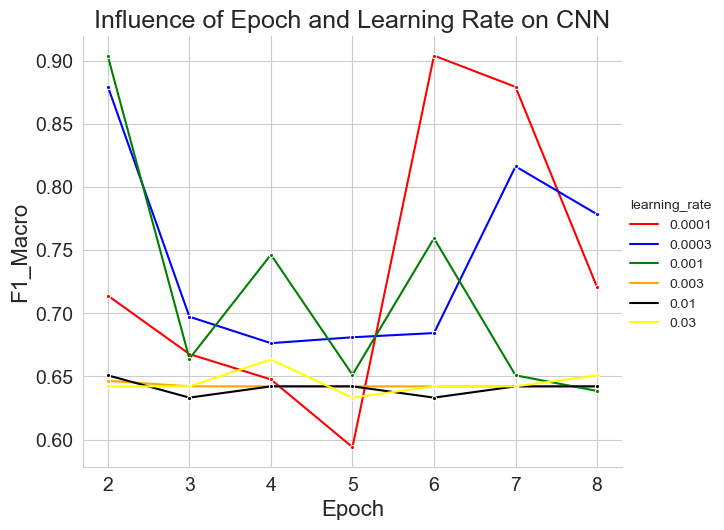

In [31]:
# 1. Line plot comparing all epochs

sns.set_style('whitegrid')
ax=sns.relplot(x='epoch', y='f1_macro_test', data=cnn_data, kind='line', hue='learning_rate',height=5, aspect=1.25, marker='.',
      palette=cnn_palette)
ax.tick_params(labelsize=14, axis = 'both')
#ax.set_xticklabels(['(2x2)', '(5x5)', '(10x10)'])
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('F1_Macro', fontsize=16)
#plt.ylim(0.3,0.9)
plt.title('Influence of Epoch and Learning Rate on CNN', fontsize=18)
#plt.savefig('f1_macro_epoch_lr.jpg', dpi=2000, bbox_inches='tight')
